<a href="https://colab.research.google.com/github/jmhuer/shift_invariant_dictionary_learning/blob/main/trace_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install skorch
!pip install tqdm
!git clone https://github.com/jmhuer/optimization_tools
!pip install alphacsc

from optimization_tools.utils import download_gdrive
train_data = '1BcbMFSk-dyoBaEvV1Wb9Z00f3j5iCp0G' ##google drive id of excell 
test_data = "1dnY7etRMDFvSLAkKUMceWBcuuJLaHnrb"

download_gdrive(train_data)
download_gdrive(test_data)

fatal: destination path 'optimization_tools' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1BcbMFSk-dyoBaEvV1Wb9Z00f3j5iCp0G
To: /content/Trace_TRAIN.xlsx
100%|##########| 286k/286k [00:00<00:00, 39.3MB/s]

Downloading...
From: https://drive.google.com/uc?id=1dnY7etRMDFvSLAkKUMceWBcuuJLaHnrb
To: /content/Trace_TEST.xlsx
100%|##########| 218k/218k [00:00<00:00, 32.2MB/s]



In [2]:
import pandas as pd

def open_excel(filename, sheet_name):
    excell = pd.ExcelFile(filename)
    excell.sheet_names
    df = excell.parse(sheet_name)
    df.columns = df.columns.map(str)
    df = df.dropna().reset_index(drop=True)
    return df

df = open_excel("/content/Trace_TRAIN.xlsx", "Trace_TRAIN")

df_test = open_excel("/content/Trace_TEST.xlsx", "Trace_TEST")
df_test.columns = df_test.columns.map(str)

In [3]:
df_test.shape[1]

276

In [4]:

for index, row in df_test.iterrows():
    print(row["class"])
    break

3.0


## Dictionary learning

In [28]:
n_times_atom = 80  # L
n_times = df.shape[1] - 1  # T (minus 1 for class column)
n_atoms = 10  # K
n_trials = df.shape[0]  # N
n_channels = 1



In [29]:
df_test.head()

,class,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253,Unnamed: 254,Unnamed: 255,Unnamed: 256,Unnamed: 257,Unnamed: 258,Unnamed: 259,Unnamed: 260,Unnamed: 261,Unnamed: 262,Unnamed: 263,Unnamed: 264,Unnamed: 265,Unnamed: 266,Unnamed: 267,Unnamed: 268,Unnamed: 269,Unnamed: 270,Unnamed: 271,Unnamed: 272,Unnamed: 273,Unnamed: 274,Unnamed: 275
0,3,-1.296736,-1.333738,-1.349496,-1.318587,-1.307479,-1.255202,-1.273145,-1.254287,-1.298989,-1.290773,-1.302922,-1.300306,-1.307352,-1.297488,-1.283953,-1.341779,-1.321968,-1.292855,-1.295657,-1.246449,-1.354392,-1.323527,-1.308674,-1.288147,-1.277163,-1.322130,-1.269480,-1.298817,-1.273018,-1.330083,-1.240804,-1.302436,-1.364067,-1.292355,-1.290224,-1.290786,-1.320876,-1.312934,-1.321681,...,0.868469,0.791706,0.848278,0.814963,0.844200,0.804676,0.830579,0.811706,0.848178,0.887963,0.885087,0.804370,0.813127,0.783253,0.847750,0.857812,0.833870,0.820761,0.870627,0.787882,0.842882,0.795660,0.823243,0.819505,0.797467,0.819306,0.825646,0.812262,0.846602,0.837655,0.817590,0.851303,0.782615,0.801945,0.821274,0.810207,0.822209,0.819276,0.816343,0.794338
1,1,0.564214,0.545116,0.542047,0.563157,0.620198,0.581974,0.598603,0.578583,0.612213,0.622150,0.651862,0.611884,0.702007,0.611253,0.592521,0.588605,0.576464,0.558298,0.597151,0.599780,0.602532,0.602304,0.630566,0.599584,0.614938,0.633425,0.547959,0.572915,0.603394,0.613553,0.592205,0.650001,0.591099,0.645992,0.631558,0.546751,0.627571,0.613915,0.542942,...,0.554533,0.500871,0.527384,0.569502,0.532444,0.512395,0.559144,0.538515,0.496172,0.563448,0.558196,0.547331,0.541925,0.541562,0.599890,0.609105,0.573793,0.537794,0.517505,0.558873,0.573294,0.585470,0.587851,0.567978,0.586527,0.520116,0.614556,0.589304,0.539558,0.576140,0.568564,0.577551,0.620840,0.520834,0.568744,0.626330,0.530965,0.571332,0.586189,0.590860
2,3,-2.100779,-2.088201,-2.025100,-2.100239,-2.086126,-2.030557,-2.057606,-2.094286,-2.019413,-2.100592,-2.077596,-2.086217,-2.067445,-2.026826,-1.988130,-2.034455,-2.073608,-2.033534,-2.043946,-2.043691,-2.047009,-2.054476,-2.029235,-2.043709,-2.071321,-2.051201,-2.066278,-2.078206,-2.038419,-2.058166,-2.048246,-2.072147,-2.067382,-1.995005,-2.038438,-2.002107,-2.010124,-2.044430,-1.979272,...,0.543562,0.501355,0.610202,0.538363,0.565945,0.510124,0.519876,0.578270,0.552150,0.526030,0.529435,0.510975,0.533750,0.598374,0.535464,0.572777,0.581516,0.506503,0.531993,0.500033,0.517366,0.507823,0.544937,0.598653,0.544034,0.595354,0.588260,0.537135,0.551000,0.534877,0.589671,0.496224,0.537520,0.558377,0.547514,0.571221,0.542142,0.542945,0.543747,0.543874
3,2,0.738442,0.728175,0.757858,0.822484,0.734091,0.760751,0.811335,0.802686,0.728860,0.703921,0.678807,0.761075,0.751167,0.817078,0.747813,0.781549,0.775656,0.757780,0.693106,0.748162,0.778360,0.699534,0.786682,0.744153,0.746283,0.832787,0.753267,0.826130,0.740835,0.772521,0.770911,0.757556,0.808293,0.789985,0.698864,0.714306,0.729749,0.802062,0.751128,...,0.732571,0.693445,0.715897,0.775099,0.712643,0.727309,0.738201,0.753473,0.751290,0.665401,0.717172,0.734121,0.681781,0.761852,0.770698,0.696792,0.706314,0.705529,0.785900,0.754598,0.737232,0.764635,0.742151,0.743498,0.693093,0.723610,0.740081,0.703261,0.733857,0.734462,0.760828,0.709781,0.750877,0.738374,0.706462,0.769492,0.705494,0.738047,0.764293,0.757955
4,1,0.637616,0.585078,0.623133,0.629319,0.641032,0.64420

In [30]:
X_train = df.loc[:,"Unnamed: 1":"Unnamed: 275"].values[:,None,:]
Y_train = df.loc[:,"class"]

X_test = df_test.loc[:,"Unnamed: 1":"Unnamed: 275"].values[:,None,:]
Y_test = df_test.loc[:,"class"]

print(X_train.shape)
print(X_test.shape)

(100, 1, 275)
(100, 1, 275)


[BatchCDL] Converged after 52 iteration, (dz, du) = 0.000e+00, 0.000e+00


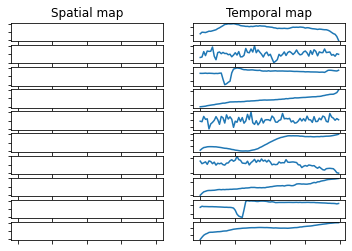

In [31]:
from alphacsc import BatchCDL
import matplotlib.pyplot as plt

# Learn a dictionary with batch algorithm and rank1 constraints.
cdl = BatchCDL(n_atoms, n_times_atom, rank1=False, verbose = 0)
cdl.fit(X_train)

# Display the learned atoms
fig, axes = plt.subplots(n_atoms, 2, num="Dictionary")
for k in range(n_atoms):
    axes[k, 0].plot(cdl.u_hat_[k])
    # print(cdl.u_hat_[k].shape, cdl.u_hat_[k])
    axes[k, 1].plot(cdl.v_hat_[k])

axes[0, 0].set_title("Spatial map")
axes[0, 1].set_title("Temporal map")
for ax in axes.ravel():
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

# Plot Utils

In [32]:
import plotly.graph_objects as graph
def plot(all_history:list, title:str, log = False):
    """
    input:
        all_history: list of dicts to plot
    ret:
        None: show plotly fig
    """
    fig = graph.Figure(layout = graph.Layout(title=graph.layout.Title(text=title))) 
    for i in range(len(all_history)):
        fig.add_trace(graph.Scatter(x = all_history[i]["x"], 
                                    y = all_history[i]["y"],
                                    name = all_history[i]["legend"])) 
    if log: fig.update_xaxes(type="log")
    fig.show()

# vizualize dictionary

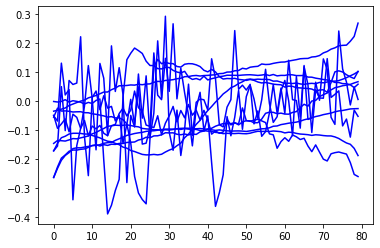

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(cdl.v_hat_.T, 'b', label=r'$\alpha$CSC')
plt.show()



# Obtain dense sparse codes as data 

In [34]:

import numpy as np

test_sparse_code = cdl.transform(X_test)
train_sparse_code = cdl.transform(X_train)

(a,b,c) = test_sparse_code.shape
X_test_flat = test_sparse_code.reshape((a, b*c))

(a,b,c) = train_sparse_code.shape
X_train_flat = train_sparse_code.reshape((a, b*c))



# testing sklearn library

In [35]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(random_state = 42, max_iter=20000)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
# pipe = Pipeline(steps=[('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 8),
    'logistic__tol': [0.3, 0.4, 0.5, 0.6,1]}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)


# Evaluate

In [36]:
from sklearn.metrics import classification_report


print(X_train_flat.shape)
search.fit(X_train_flat, Y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Y_pred = search.predict(X_test_flat)
print(Y_test.values)
print(Y_pred)

print(classification_report(Y_test.values, Y_pred))


(100, 1960)
Best parameter (CV score=0.790):
{'logistic__C': 0.019306977288832496, 'logistic__tol': 0.3, 'pca__n_components': 30}
[3 1 3 2 1 3 2 2 2 4 3 2 3 3 3 4 2 3 1 1 3 4 4 1 2 3 3 4 3 4 3 2 2 2 1 4 3
 1 2 4 3 4 2 2 4 2 1 4 4 3 2 4 2 1 3 1 3 1 3 3 3 1 3 2 4 1 2 1 2 1 1 2 3 4
 1 2 2 4 3 2 2 1 4 1 2 2 4 1 1 1 3 1 1 2 3 3 2 2 3 4]
[4 1 4 1 1 4 2 2 1 4 4 1 4 3 4 4 1 4 1 1 4 4 3 1 1 4 3 4 4 4 4 2 2 1 1 4 4
 1 1 4 3 4 1 1 4 2 1 4 4 4 2 4 1 1 4 1 4 1 3 3 4 1 4 1 4 1 2 1 1 1 1 1 3 4
 1 1 1 4 4 1 2 1 4 1 1 1 4 1 1 1 4 1 1 2 4 3 1 1 4 4]
              precision    recall  f1-score   support

           1       0.55      1.00      0.71        24
           2       1.00      0.31      0.47        29
           3       0.88      0.25      0.39        28
           4       0.46      0.95      0.62        19

    accuracy                           0.58       100
   macro avg       0.72      0.63      0.55       100
weighted avg       0.75      0.58      0.53       100



# Recunstruct

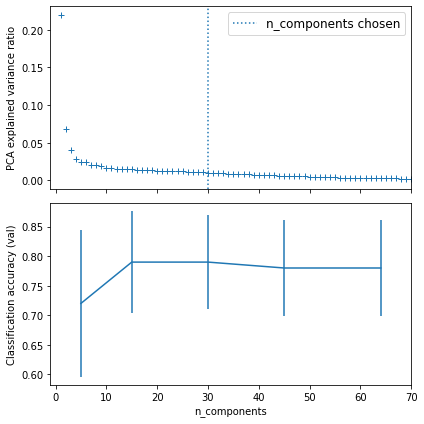

In [37]:

# Plot the PCA spectrum
pca.fit(X_train_flat)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

In [38]:

sparse_code = cdl.transform(X_test[0,:,:][None])
print("\nsparse_code.shape", sparse_code.shape)
# np.savetxt("foo.csv", sparse_code[0,:,:], delimiter=",")

X_test_reconstruct = cdl.transform_inverse(sparse_code)

print("\nX_test.shape: {} \nX_test_reconstruct.shape : {}".format(X_test.shape, X_test_reconstruct[0,0,:].shape))

#perfect plot
original_plot = {"legend": "original", 
                 "x": list(range(0,276)), 
                 "y": X_test[0,0,:]}
                  
reconstruct_plot = {"legend": "reconstruct", 
                    "x": list(range(0,276)),
                    "y": X_test_reconstruct[0,0,:]}      

plot([original_plot, reconstruct_plot], "Signal Comparison")      



sparse_code.shape (1, 10, 196)

X_test.shape: (100, 1, 275) 
X_test_reconstruct.shape : (275,)
